# Classifying Names with a Char-Level RNN

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preparing Data

In [2]:
from io import open
import glob, os

In [3]:
def findFiles(path): return glob.glob(path)

In [4]:
print(findFiles('/content/drive/MyDrive/datasets/names/*.txt'))

['/content/drive/MyDrive/datasets/names/Italian.txt', '/content/drive/MyDrive/datasets/names/German.txt', '/content/drive/MyDrive/datasets/names/Greek.txt', '/content/drive/MyDrive/datasets/names/Irish.txt', '/content/drive/MyDrive/datasets/names/French.txt', '/content/drive/MyDrive/datasets/names/Japanese.txt', '/content/drive/MyDrive/datasets/names/Korean.txt', '/content/drive/MyDrive/datasets/names/Scottish.txt', '/content/drive/MyDrive/datasets/names/Vietnamese.txt', '/content/drive/MyDrive/datasets/names/Chinese.txt', '/content/drive/MyDrive/datasets/names/Dutch.txt', '/content/drive/MyDrive/datasets/names/Spanish.txt', '/content/drive/MyDrive/datasets/names/English.txt', '/content/drive/MyDrive/datasets/names/Polish.txt', '/content/drive/MyDrive/datasets/names/Portuguese.txt', '/content/drive/MyDrive/datasets/names/Russian.txt', '/content/drive/MyDrive/datasets/names/Arabic.txt', '/content/drive/MyDrive/datasets/names/Czech.txt']


In [5]:
import unicodedata, string

In [6]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [7]:
n_letters

57

In [8]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [9]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [10]:
category_lines = {}
all_categories = []

In [11]:
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [12]:
for filename in findFiles('/content/drive/MyDrive/datasets/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [13]:
n_categories

18

In [14]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## Turning Names into Tensors

In [15]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [16]:
print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## Creating the Network

In [17]:
import torch.nn as nn

In [18]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [19]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [20]:
rnn

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [21]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [22]:
input, output

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.]]),
 tensor([[-2.8407, -2.9251, -2.9372, -2.8802, -2.8854, -2.7861, -2.8753, -2.9378,
          -2.8555, -2.9446, -2.9825, -2.8439, -2.9202, -2.8294, -2.9104, -2.9115,
          -2.8314, -2.9533]], grad_fn=<LogSoftmaxBackward0>))

In [23]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
input, output

(tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0.,

## Training

### Preparing for Training

In [24]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    # print(category_i)
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Japanese', 5)


In [25]:
import random

def random_choice(l):
    return l[random.randint(0, len(l)-1)]

def random_training_example():
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_example()
    print('category =', category, '/ line =', line)

category = German / line = Feldt
category = Japanese / line = Ota
category = Russian / line = Golofaev
category = Japanese / line = Torisei
category = English / line = Sheldon
category = Chinese / line = Tow
category = English / line = Tosh
category = Spanish / line = Prieto
category = Arabic / line = Fakhoury
category = German / line = Blecher


### Training the Network

In [26]:
criterion = nn.NLLLoss()
learning_rate = 0.005

In [27]:
def train(category_tensor, line_tensor):
    hidden = rnn.init_hidden()
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [28]:
import time, math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = random_training_example()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = 'T' if guess == category else 'F (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter/n_iters*100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 18s) 2.7376 Ogden / Irish F (English)
10000 10% (0m 25s) 2.7945 Steinmann / Irish F (German)
15000 15% (0m 33s) 2.4803 Whyte / English F (Scottish)
20000 20% (0m 39s) 3.6835 Houttum / Arabic F (Dutch)
25000 25% (0m 47s) 0.9029 Quyen / Vietnamese T
30000 30% (0m 54s) 1.7998 Jaso / Italian F (Spanish)
35000 35% (1m 1s) 1.9940 Kings / Dutch F (English)
40000 40% (1m 8s) 0.6170 Phan / Vietnamese T
45000 45% (1m 15s) 0.7761 Nosek / Polish T
50000 50% (1m 23s) 0.4701 Lemaire / French T
55000 55% (1m 30s) 0.3688 Yamazaki / Japanese T
60000 60% (1m 37s) 2.4193 Siegl / Dutch F (Czech)
65000 65% (1m 45s) 1.2031 Patril / Czech T
70000 70% (1m 52s) 3.9695 Trudu / Vietnamese F (Italian)
75000 75% (2m 0s) 0.9970 Sayegh / Arabic T
80000 80% (2m 7s) 0.6722 Omori / Japanese T
85000 85% (2m 15s) 1.9923 Adami / Arabic F (Italian)
90000 90% (2m 22s) 1.2255 Fiore / Italian T
95000 95% (2m 30s) 0.2521 Seegers / Dutch T
100000 100% (2m 36s) 1.4569 Samaha / Japanese F (Arabic)


### Plotting the Results

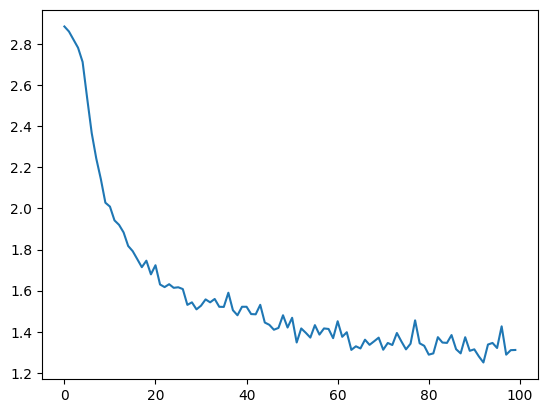

In [29]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Evaluating the Results

<ipython-input-30-564d99573387>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-30-564d99573387>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


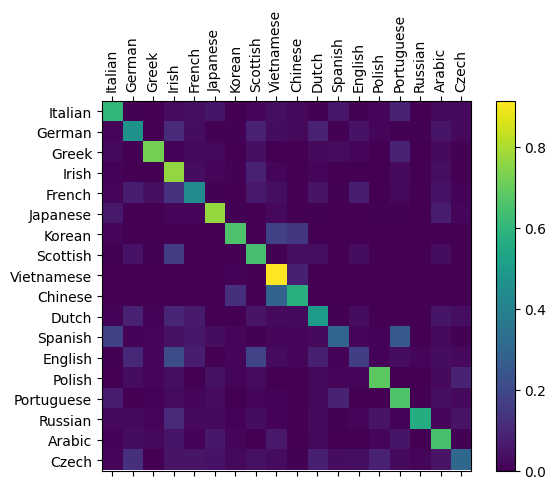

In [30]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_example()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

## Running on User Input

In [31]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [32]:
predict('Dostoevesky')


> Dostoevesky
(-0.69) Czech
(-1.79) Russian
(-1.99) Polish


In [37]:
predict('Cilian')


> Cilian
(-0.47) Irish
(-2.41) Scottish
(-2.72) English


In [34]:
predict('Shiro')


> Shiro
(-1.24) Chinese
(-1.24) Japanese
(-1.74) Vietnamese
